<a href="https://colab.research.google.com/github/RGTHENO/Logistic-Regression-Regresion-Logistica/blob/master/RegresionLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

np.set_printoptions(suppress=True)
DRIVE_PATH = './drive/My Drive/Colab Notebooks/TopIA/RegresionLogistica/'
drive.mount('/content/drive') 

PERCENTAGE_TRAINING = 0.5
PERCENTAGE_TESTING = 0.3
THRESHOLD = 0.5

DATASET_NAME_DIABETES = 'diabetes.csv'
DATASET_NAME_ENF_CARD = 'enfermedad_cardiaca.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 def readFiles(filename:str):

  dataframe = pd.read_csv(filename, delim_whitespace=True) 
  matrix_data = dataframe.to_numpy() 
  
  '''We are gonna assure that dtype of each element of matrix_data
  to be float64, this way it will be better to work with normalized values'''
  matrix_data = matrix_data.astype(np.float64) 
  
  return matrix_data
   


In [0]:
matrix_data = readFiles(DRIVE_PATH+DATASET_NAME_DIABETES) 

In [0]:
def normalizeData(matrix_data):

  #calculate the 'mean' y 'stdeviation' of all rows per each Column'''  
  #Normalize for all columns of the jth row, except last column (Y) that contains 0's,1's values
  for col in range(matrix_data.shape[1] -1 ):

      mean_row             =  np.mean(matrix_data[:,col]) 
      std_row              =  np.std(matrix_data[:, col] )
      matrix_data[ :, col] =  ( matrix_data[:, col]-(mean_row) )/(std_row)
  
  return matrix_data

In [0]:
def sigmoidalFunction(X, theta):
  z = X.dot(theta) 
  g = 1.0/(1.0+np.exp(-z))
  return g

In [0]:
def computeCost( X , Y, theta ):

  m_samples =  len(Y)
  pred_Y    =  sigmoidalFunction(X,theta)  
  J         =  (1/m_samples)*np.sum(-Y*np.log(pred_Y) - (1-Y)*np.log(1-pred_Y), axis=0)
  return J

In [0]:
def computeGradient(X,Y,theta): 
  f =  sigmoidalFunction(X,theta) - Y  #  return a matrix of shape--> mx1 
  return X.T.dot(f)                    # (nxm)dot(mx1) --> (nx1) 'cause theta is a vector (nx1)

In [0]:
def gradientDescent(X , Y , theta, n_iteration, l_rate ):

  m_samples   = float( len(Y) )
  cost_record = np.zeros(n_iteration)
  
  for i in range(n_iteration):

      gradient       = computeGradient(X,Y,theta)
      theta          = theta-(1/m_samples)*l_rate*gradient
      cost_record[i] = computeCost(X, Y, theta)
  
  return theta, cost_record


In [0]:
def distributionData( matrix_data):
   
    total_samples = matrix_data.shape[0]
    n_class1      = int( np.sum( matrix_data[:,-1], axis=0) )
    n_class0      = int( total_samples - n_class1)
    p_class1      = round( n_class1/total_samples, 2) # Round to 2 decimals
    p_class0      = 1-p_class1  

    return n_class1, p_class1, n_class0, p_class0


In [0]:
def createFolds(MATRIX_DATA, kfolds:int):
  
  n_class1, p_class1, n_class0, p_class0 = distributionData(MATRIX_DATA)
  m_samples = MATRIX_DATA.shape[0]
  
  #Pertubate data before to agroup samples based on their respective classes
  #'cause when we apply sort, these will arrive as they are
  indices_perturbed = np.random.permutation(MATRIX_DATA.shape[0]) 
  MATRIX_DATA       = MATRIX_DATA[indices_perturbed]

  #Rows of class0 will appear first, eventually class1 will appear
  indexSorted_Y = np.argsort( MATRIX_DATA[:,-1] ); 
  MATRIX_DATA   = MATRIX_DATA[indexSorted_Y,:]

  # array_split returns l% n sub-arrays of size l//n + 1 and the rest of size l//n
  folds_class0 = np.array_split(MATRIX_DATA[0:n_class0], kfolds)
  folds_class1 = np.array_split(MATRIX_DATA[n_class0:m_samples], kfolds)


  #Here, doesnt matter to add more pertubation because always will be the same
  #at the end of revisiting all the training samples
  matrix_folds = []
  for k in range (0, kfolds):
    matrix_folds.append( np.vstack( (folds_class0[k], folds_class1[k] ) ) )

  return matrix_folds 
    


In [0]:
def computeAccuracy(X,Y,theta):

  m_samples = Y.shape[0]

  #We're going to get all probabilities returned from sigmoidFunction
  Y_estimated = sigmoidalFunction(X,theta)
  
  #We'going to apply THRESHOLD to each probability to get 0's or 1's
  Y_estimated = [ float( y_i > THRESHOLD ) for y_i in Y_estimated  ] 

  #Let's count how many much we'll get between Y_predicted and Y truth
  n_match=0
  for i in range(m_samples):
      if(Y_estimated[i] == Y[i,0]): #Remember that Y is (m x 1) vector
        n_match+=1

  accuracy = n_match/m_samples
  return accuracy

In [0]:
def computeAccFolds( kfolds: [], list_theta  ):

  '''OJO!!! :The folds will be taken as TEST DATA in the following order :fold0, fold1, fol2 '''
  k = len(kfolds)   
  accFolds = np.zeros( (k,1) ) # A vector (k x 1)

  for i in range(0, k):
        X_test_fold = kfolds[i]
        Y_test_fold = X_test_fold[:,-1]

        #It's very important to reshape as Y is a vector Vertical(mx1)
        Y_test_fold = np.reshape(Y_test_fold, (Y_test_fold.shape[0] ,1) )

        X_test_fold = X_test_fold[:,:-1]
        
        theta_i = list_theta[i]
        accFolds[i,0] = computeAccuracy(X_test_fold, Y_test_fold, theta_i)

  return np.mean(accFolds, axis=0)


In [0]:
def computeGDFolds(kfolds:[], n_iteraciones, alpha):
    
    k = len(kfolds)

    list_thetas      = []
    list_costs       = []

    for test_i in range( 0, k):

         #Let's create an empty matrix to concatenate matrix to form a Matrix Train
          folds_train = np.zeros( (0, len( kfolds[0][0]) ) ) # (0x9), where 9 is the number of features of DIABETES
          
          for train_i in range(0,k):
              if( test_i != train_i):
                folds_train = np.vstack((folds_train, kfolds[train_i]) )
          
          #Let's partition into X_train and Y_train
          X_train = folds_train[:, :-1]
          Y_train = folds_train[:, -1] 

          #It's very important to reshape as Y is a vector Vertical(mx1)
          Y_train = np.reshape(Y_train, (Y_train.shape[0] ,1) )

          theta =  np.zeros( ( X_train.shape[1], 1)) 

          theta, cost_tmp = gradientDescent(X_train, Y_train, theta, n_iteraciones,
                                            alpha)  

          list_thetas.append(theta)
          list_costs.append(cost_tmp)

    return list_thetas, list_costs

In [0]:
def searchBestParameters(folds:[]):

      iteration_list     = range(500, 4000, 500) #500, 1000, ..., 3500
      learning_rate_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
      
      #Matrix : Iteration vs Learning Rate
      matrix_lr_it =  np.zeros((len(iteration_list ), len(learning_rate_list)) )

      best_it= -1.0
      best_lr=-1.0
      
      max_acc_folds = 0.00000

      for i in range( 0, len(iteration_list) ):
          for alpha in range( 0, len(learning_rate_list) ):
          
              list_theta, list_cost  = computeGDFolds( folds, iteration_list[i], learning_rate_list[alpha] )
              matrix_lr_it[i, alpha] = computeAccFolds(folds, list_theta)

              
              if( matrix_lr_it[i, alpha] > max_acc_folds ):
                  best_it = iteration_list[i]
                  best_lr = learning_rate_list[alpha]
                  max_acc_folds = matrix_lr_it[ i, alpha]
              

      dframe_MatrixBestParam  = pd.DataFrame(matrix_lr_it, 
                                             index= iteration_list,
                                             columns= learning_rate_list)
      
      print("Max acuracy: ", max_acc_folds, " cuando iteraciones :", best_it,
            ", alpha :", best_lr)
         
      return dframe_MatrixBestParam
      

In [0]:
fileDIABETES = DRIVE_PATH+DATASET_NAME_DIABETES
fileENFCARD = DRIVE_PATH+DATASET_NAME_ENF_CARD

matrix_data_diabetes = readFiles(fileDIABETES)  
matrix_data_enfcard  = readFiles(fileENFCARD)

matrix_data_diabetes = normalizeData( matrix_data_diabetes)
matrix_data_diabetes = normalizeData( matrix_data_enfcard )

k = 3
kfolds_matrix_diabetes = createFolds(matrix_data_diabetes, k)
kfolds_matrix_enfcard = createFolds(matrix_data_enfcard, k)


In [37]:
searchBestParameters(kfolds_matrix_enfcard)

Max acuracy:  0.834983498349835  cuando iteraciones : 2000 , alpha : 0.01


,0.01,0.05,0.10,0.20,0.30,0.40
500,0.828383,0.831683,0.821782,0.825083,0.825083,0.825083
1000,0.831683,0.821782,0.825083,0.825083,0.825083,0.825083
1500,0.831683,0.825083,0.825083,0.825083,0.825083,0.825083
2000,0.834983,0.825083,0.825083,0.825083,0.825083,0.825083
2500,0.831683,0.825083,0.825083,0.825083,0.825083,0.825083
3000,0.831683,0.825083,0.825083,0.825083,0.825083,0.825083
3500,0.831683,0.825083,0.825083,0.825083,0.825083,0.825083


In [38]:
searchBestParameters(kfolds_matrix_diabetes)

Max acuracy:  0.8283828382838284  cuando iteraciones : 500 , alpha : 0.01


,0.01,0.05,0.10,0.20,0.30,0.40
500,0.828383,0.815182,0.815182,0.808581,0.808581,0.808581
1000,0.815182,0.811881,0.808581,0.808581,0.808581,0.808581
1500,0.825083,0.808581,0.808581,0.808581,0.808581,0.808581
2000,0.818482,0.808581,0.808581,0.808581,0.808581,0.808581
2500,0.815182,0.808581,0.808581,0.808581,0.808581,0.808581
3000,0.815182,0.808581,0.808581,0.808581,0.808581,0.808581
3500,0.815182,0.808581,0.808581,0.808581,0.808581,0.808581


In [0]:
def plotCostvsIter( cost_history: np.array, title_graph ):

    fig,axis_fig = plt.subplots(figsize=(12,8)) 
    num_iteraciones = cost_history.shape[0]
    scale = 1.0
    axis_fig.set(xlim = [-10,num_iteraciones], ylim = (cost_history[-1]-0.058,cost_history[0]))
    axis_fig.grid(True)
    axis_fig.set_ylabel('J(Theta)')
    axis_fig.set_xlabel('Iterations')
    axis_fig.plot(range(num_iteraciones),cost_history,'b.')
    plt.title(title_graph, {'fontsize':10})
    plt.show()

    fig.savefig(title_graph + ".jpg")
    from google.colab import files
    files.download(title_graph + ".jpg")

In [0]:
num_iteraciones = 1000
lr = 0.4
theta_diabetes, cost_diabetes = computeGDFolds(kfolds_matrix_diabetes, num_iteraciones, lr)
theta_enfcard, cost_enfcard = computeGDFolds(kfolds_matrix_enfcard, num_iteraciones, lr)

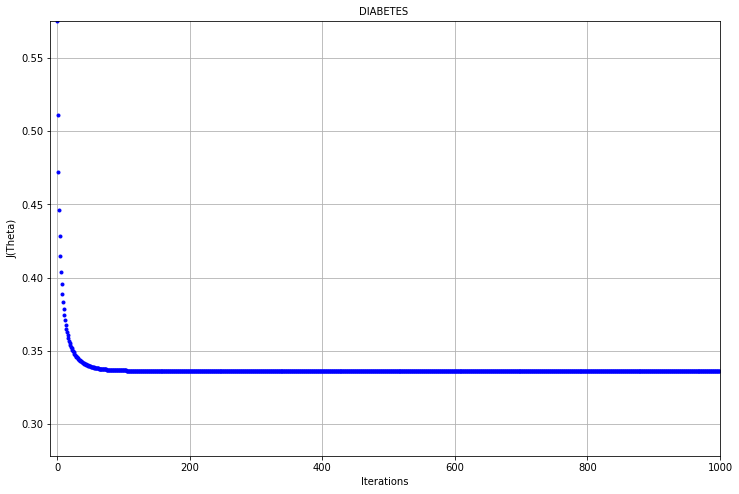

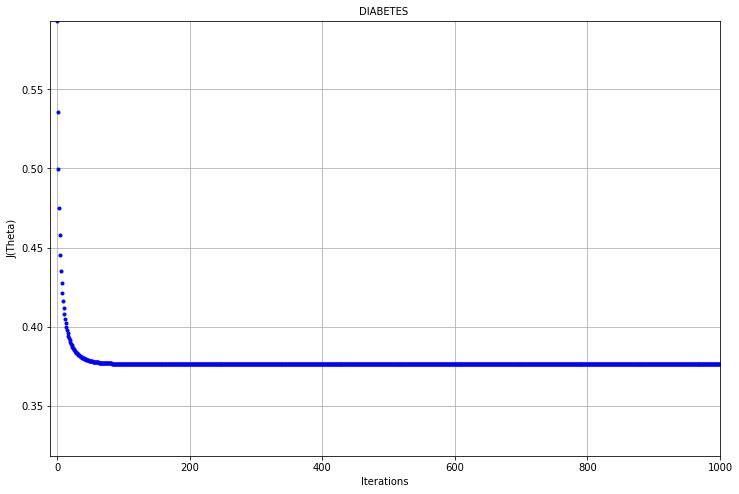

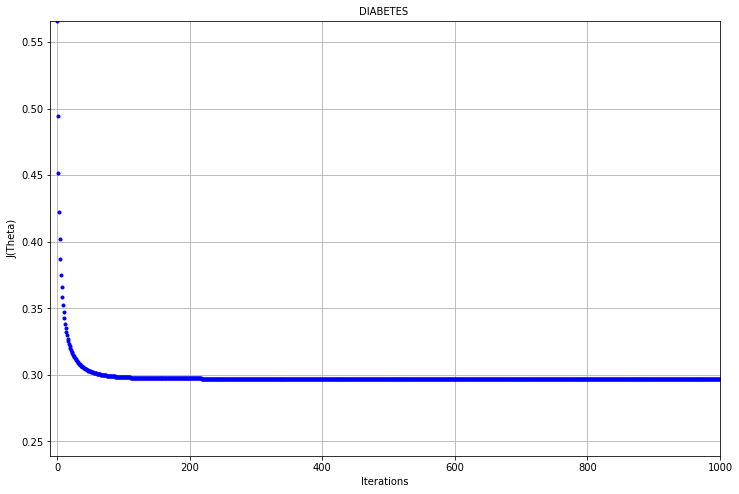

El promedio de las acuracias es : [0.80858086]


In [41]:
#DIABETES
for i in range(0, k):
    plotCostvsIter(cost_diabetes[i], "DIABETES ")

avgAccDiabetes = computeAccFolds(kfolds_matrix_diabetes, theta_diabetes)
print("El promedio de las acuracias es :",avgAccDiabetes )


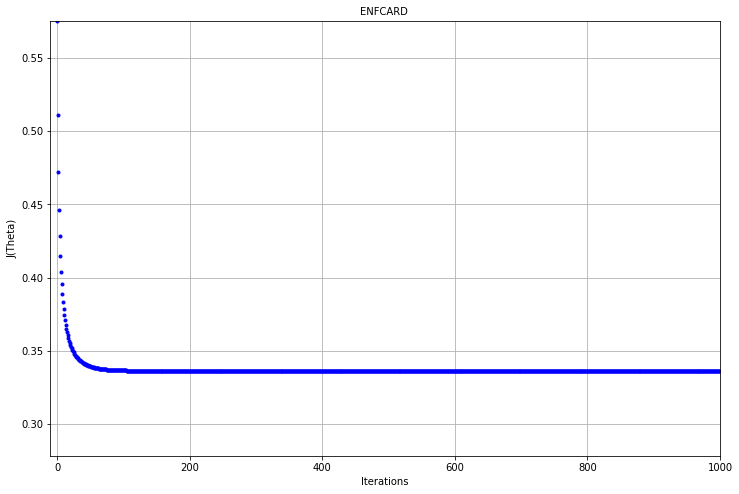

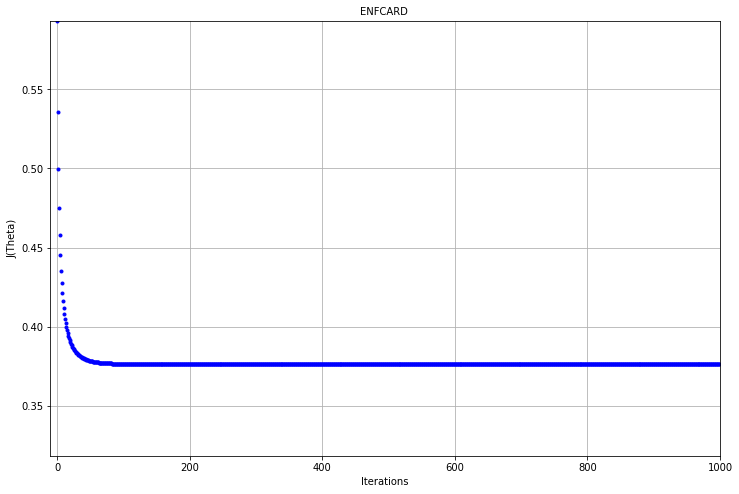

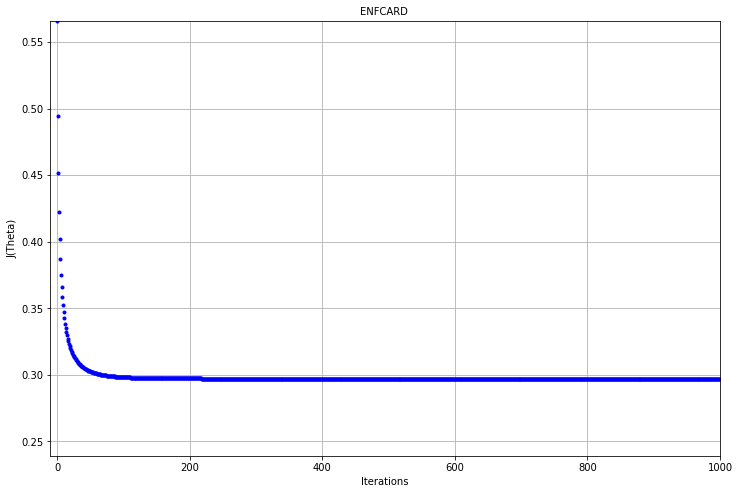

El promedio de las acuracias es : [0.82508251]


In [42]:
#ENFCARD
for i in range(0, k):
    plotCostvsIter(cost_diabetes[i], "ENFCARD ")

avgAccEnfCard = computeAccFolds(kfolds_matrix_enfcard, theta_enfcard)
print("El promedio de las acuracias es :",avgAccEnfCard )